In [1]:
from rna_results_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Raw data is obtained from https://predictioncenter.org/download_area/CASP15/results/tables/

groups and target types were hand annotated

other csv is place holder until all scores on website - unclear if most recent data as of now

In [3]:
# read data
rna = pd.read_csv("230903_rck_add_inf_rna.csv")
rna['gr_code']=rna['gr_code'].apply(lambda x: '{0:0>3}'.format(x))

group_details = pd.read_csv("groups_casp15_types.csv",skiprows=[0])
group_details['gr_code']=group_details['groups'].apply(lambda x: '{0:0>3}'.format(x))
group_names = dict(zip(group_details["gr_code"], group_details["group_name"]))

em_df = rna[rna.target.isin(["R1126","R1128","R1136","R1138","R1149","R1156",])].copy()

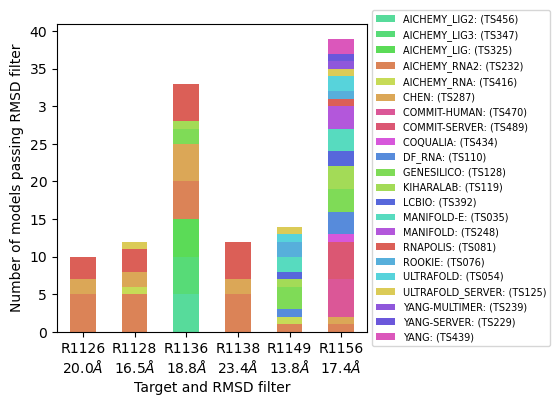

In [4]:
rmsd_lims = {'R1126':20, 'R1128':16.5, 'R1136':18.8,
       'R1138':23.4, 'R1149':13.8, 'R1156':17.4}
new_EM_only = em_df[em_df.apply(lambda row: (row.global_rmsd <= rmsd_lims[row.target]) & (row.global_rmsd>0),axis=1)].copy()

new_EM_only["group"] = new_EM_only["gr_code"].apply(lambda x: f"{group_names[x]}: (TS{str(x)})")

count_filter = new_EM_only.groupby(['target', 'group']).size().unstack()
count_filter = count_filter.loc[:, (count_filter != 0).any(axis=0)]

palette_colors = sns.color_palette("hls", 22)
palette_dict = {x: color for x, color in zip(new_EM_only.group.unique(), palette_colors)}

ax = count_filter.plot(kind='bar', stacked=True, color=palette_dict,figsize=(4,4))
t=ax.set_yticks([0,5,10,15,20,25,30,35,40], [0,5,10,15,20,25,3,35,40], rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=7)
ax.set_ylabel("Number of models passing RMSD filter")
ax.set_xlabel("Target and RMSD filter")
ax.set_xticks(ax.get_xticks(),labels=["R1126\n20.0$\AA$","R1128\n16.5$\AA$","R1136\n18.8$\AA$","R1138\n23.4$\AA$","R1149\n13.8$\AA$","R1156\n17.4$\AA$"],rotation=0)
plt.savefig("filter_for_EM_scoring.png",dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("filter_for_EM_scoring.svg", bbox_inches='tight', transparent=True)

In [5]:
labels = {'clashscore':'clashscore', 'global_rmsd':"RMSD", 'cc_mask':"CCmask",
       'cc_peaks':"CCpeaks", 'tempy_mi':"MI", 'tempy_smoc':"SMOC", 'ai':"AI",'gdt_ts':"GDT-TS", 'tm_score':"TM", 'lddt':"lDDT","inf_all":"INF"
}
col_to_plot = ['clashscore', 'global_rmsd', 'cc_mask',
       'cc_peaks', 'tempy_mi', 'tempy_smoc', 'ai','gdt_ts', 'tm_score', 'lddt','inf_all']

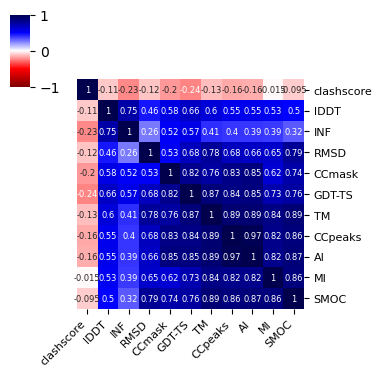

In [6]:
corr_total = None
nonnan_count = None

for target in new_EM_only.target.unique():
    # get spearman correlation of just the puzzle and the columns you want
    x = new_EM_only[new_EM_only.target==target][col_to_plot].copy().apply(lambda x: -x if METRICS[x.name]=="min" else x)
    corr = x.corr(method="spearman")
    # get non-nan number
    count = ~np.isnan(corr)
    corr[~count] = 0
    if corr_total is not None:
        corr_total += corr
        nonnan_count += count.astype(int)
    else: 
        corr_total = corr
        nonnan_count = count.astype(int)
corr_avg = corr_total/nonnan_count
corr_avg = corr_avg.rename(columns=labels,index=labels)
g = sns.clustermap(corr_avg, vmin=-1, vmax=1,cmap="seismic_r",figsize=(4,4),method='complete',tree_kws={"color":"white"},annot=True,
                  annot_kws={"size":6})
l=plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45,ha="right",size=8)
l=plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0,size=8)
plt.savefig("metric_correlation_filtered.png",dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("metric_correlation_filtered.svg", bbox_inches='tight', transparent=True)

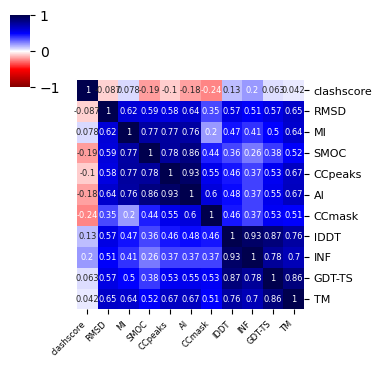

In [7]:
corr_total = None
nonnan_count = None
for target in em_df.target.unique():
    # get spearman correlation of just the puzzle and the columns you want
    x = em_df[em_df.target==target][col_to_plot].copy().apply(lambda x: -x if METRICS[x.name]=="min" else x)
    corr = x.corr(method="spearman")
    # get non-nan number
    count = ~np.isnan(corr)
    corr[~count] = 0
    if corr_total is not None:
        corr_total += corr
        nonnan_count += count.astype(int)
    else: 
        corr_total = corr
        nonnan_count = count.astype(int)
corr_avg = corr_total/nonnan_count
corr_avg = corr_avg.rename(columns=labels,index=labels)
g = sns.clustermap(corr_avg, vmin=-1, vmax=1,cmap="seismic_r",figsize=(4,4),method='complete',tree_kws={"color":"white"},annot=True,
                  annot_kws={"size":6})
l=plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45,ha="right",size=6)
l=plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0,size=8)
plt.savefig("metric_correlation_unfiltered.png",dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("metric_correlation_unfiltered.svg", bbox_inches='tight', transparent=True)

In [8]:
# for each group, take best value over all models
temp_df = reduce_df(rna,static_columns=["target","gr_code"])

# for each metric and puzzle, calcualte Z-scores
for metric in METRICS.keys():
    temp_df["Z_"+metric] = get_zscore(temp_df[metric].to_numpy(copy=True),negative=(METRICS[metric]=="min"),threshold=-2)
    
# get weighted sum Zs of interest
Z_rna = {"lddt":1/8,"tm_score":1/3,"gdt_ts":1/3,'clashscore':1/12,"inf_all":1/8} 
Z_em = {'cc_mask':1/5,'cc_peaks':1/5,'tempy_mi':1/5,'tempy_smoc':1/5,'ai':1/5}
Z_topo = {"tm_score":1/2,"gdt_ts":1/2}
Z_local = {"inf_all":1/2,"lddt":1/2} 

temp_df["Z_rna"] = get_weighted_sum_z(temp_df,Z_rna,"Z_")
temp_df["Z_em"] = get_weighted_sum_z(temp_df,Z_em,"Z_")
temp_df["Z_topo"] = get_weighted_sum_z(temp_df,Z_topo,"Z_")
temp_df["Z_local"] = get_weighted_sum_z(temp_df,Z_local,"Z_")

combing the following columns: ['model', 'ai_bb', 'ai_base', 'id']


In [9]:
# get group scores, sum > 0
group_score = get_group_score(temp_df)
# get rank with tiebreaker as the average score
group_score["tie"] = get_group_score(temp_df,agg="mean").Z_rna
rank_ = group_score.sort_values(['Z_rna','tie'], ascending=False).gr_code.values
group_score_df = pd.DataFrame(rank_,columns=["gr_code"])
group_rank_df = pd.DataFrame(rank_,columns=["gr_code"])

cols = ["rna","topo","tm_score","gdt_ts","global_rmsd","local","inf_all","lddt","clashscore"]
prefix = "Z_"
cols = ["Z_"+x for x in cols]

for metric in cols:
    group_score = get_group_score(temp_df,score=metric)
    group_score_df = group_score_df.merge(group_score,on="gr_code")
    group_score["tie"] = get_group_score(temp_df,agg="mean",score=metric)[metric]
    rank = group_score.sort_values([metric,'tie'], ascending=False).gr_code.values    
    group_rank_df[metric] = group_rank_df.gr_code.apply(lambda x: np.where(rank==x)[0][0]+1)
group_score_df["gr_code"] = group_score_df["gr_code"].apply(lambda x: f"{group_names[x]}: (TS{x})")
group_rank_df["gr_code"] = group_rank_df["gr_code"].apply(lambda x: f"{group_names[x]}: (TS{x})")
group_score_df = group_score_df.set_index("gr_code")
group_rank_df = group_rank_df.set_index("gr_code")

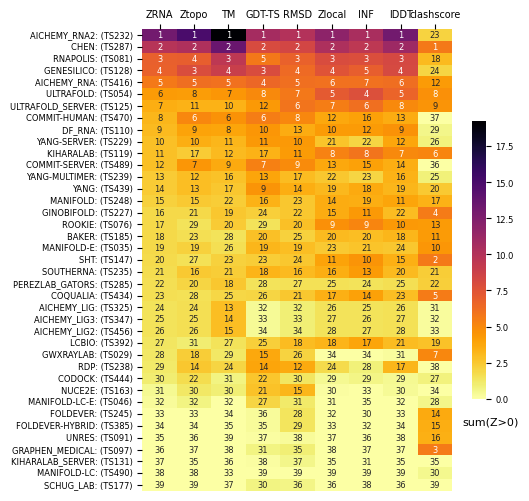

In [10]:
labels = {"rna":"ZRNA","topo":"Ztopo","tm_score":"TM","gdt_ts":"GDT-TS","global_rmsd":"RMSD",
          "local":"Zlocal","inf_all":"INF","lddt":"lDDT",
          "clashscore":"clashscore"}
labels = {prefix+x:y for x,y in labels.items()}
group_score_df = group_score_df.rename(columns=labels)

plt.figure(figsize=(5,6))
g = sns.heatmap(group_score_df,cmap="inferno_r",annot=group_rank_df,cbar_kws={'shrink': 0.6},
               annot_kws={"size":6},yticklabels=group_score_df.index)
t=g.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=6)
t=g.set_xticklabels(labels=g.get_xticklabels(),rotation = 0,size=7)
g.set_ylabel("")
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.set_label("sum(Z>0)",size=8,ha='right',y=-0.1, rotation=0, va='bottom')
g.xaxis.tick_top()
plt.savefig("Zrank_bymetric_alltargets.png",dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("Zrank_bymetric_alltargets.svg", bbox_inches='tight', transparent=True)

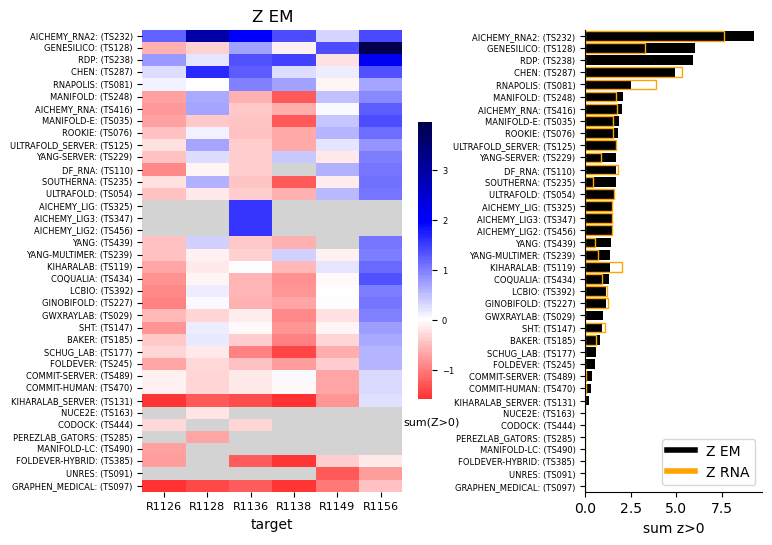

In [11]:
from matplotlib.gridspec import GridSpec

score = "Z_em"

em_df = temp_df[temp_df.target.isin(["R1126","R1128","R1136","R1138","R1149","R1156",])].copy()

group_score = get_group_score(em_df,score=score)
group_score["tie"] = get_group_score(em_df,agg="mean",score=score)[score]
rank_order = group_score.sort_values([score,'tie'], ascending=False).gr_code.values

fig = plt.figure(figsize=(8,6))
gs = GridSpec(3, 5,wspace=4)
ax_main = plt.subplot(gs[0:3, :3])
ax_yDist = plt.subplot(gs[0:3, 3:], sharey=ax_main)

em_df['gr_code'] = pd.Categorical(em_df['gr_code'],ordered=True,categories=rank_order)
pivot_all = em_df.pivot_table(index="gr_code",columns="target",values=score, dropna=False)
mask = np.isnan(pivot_all)
g = sns.heatmap(pivot_all,cmap="seismic_r",ax=ax_main, center=0,yticklabels=[f"{group_names[x]}: (TS{x})" for x in rank_order],
               cbar_kws={'shrink': 0.6},mask=mask) # annot=True, 
t=g.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=6)
t=g.set_xticklabels(labels=g.get_xticklabels(),rotation = 0,size=8)
g.set_ylabel("")
g.set_title("Z EM")
g.set_facecolor('lightgrey')
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.set_label("sum(Z>0)",size=8,ha='right',y=-0.1, rotation=0, va='bottom')
pivot_all["sum z>0"] = pivot_all.where(pivot_all > 0).sum(1)
plt.barh(g.get_yticks(),width=pivot_all["sum z>0"],color="black")
zrna_scores = get_group_score(em_df)
plt.barh(g.get_yticks(),width=zrna_scores.Z_rna,edgecolor="orange", fill=False)
t=ax_yDist.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=6)
ax_yDist.spines['right'].set_visible(False)
ax_yDist.spines['top'].set_visible(False)
ax_yDist.set_xlabel("sum z>0")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="black", lw=4),
                Line2D([0], [0], color="orange", lw=4)]

ax_yDist.legend(custom_lines, ['Z EM', 'Z RNA'],loc='lower right')
plt.savefig("EM_scores_unfiltered.png",dpi=400, bbox_inches='tight')
plt.savefig("EM_scores_unfiltered.svg", bbox_inches='tight')

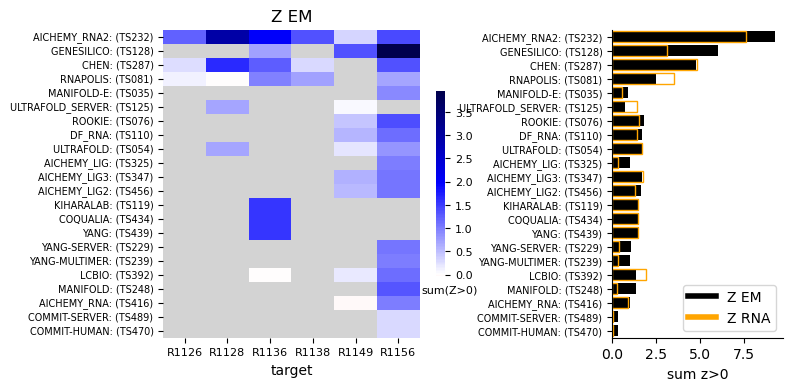

In [12]:
rmsd_lims = {'R1126':20, 'R1128':16.5, 'R1136':18.8,
       'R1138':23.4, 'R1149':13.8, 'R1156':17.4}
new_EM_only = em_df[em_df.apply(lambda row: (row.global_rmsd <= rmsd_lims[row.target]) & (row.global_rmsd>0),axis=1)].copy()

new_EM_only["group"] = new_EM_only["gr_code"].apply(lambda x: f"{group_names[x]}: (TS{str(x)})")

score = "Z_em"

group_score = get_group_score(new_EM_only,score=score)
group_score["tie"] = get_group_score(new_EM_only,agg="mean",score=score)[score]
group_score = group_score[~np.isnan(group_score.tie)]
rank_order = group_score.sort_values([score,'tie'], ascending=False).gr_code.values

fig = plt.figure(figsize=(8,4))
gs = GridSpec(3, 5,wspace=6)
ax_main = plt.subplot(gs[0:3, :3])
ax_yDist = plt.subplot(gs[0:3, 3:], sharey=ax_main)

new_EM_only['gr_code'] = pd.Categorical(new_EM_only['gr_code'],ordered=True,categories=rank_order)
pivot_all = new_EM_only.pivot_table(index="gr_code",columns="target",values=score, dropna=True)
mask = np.isnan(pivot_all)
g = sns.heatmap(pivot_all,cmap="seismic_r",ax=ax_main, center=0,yticklabels=[f"{group_names[x]}: (TS{x})" for x in rank_order],
               cbar_kws={'shrink': 0.6},mask=mask) # annot=True, 
t=g.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=7)
t=g.set_xticklabels(labels=g.get_xticklabels(),rotation = 0,size=8)
g.set_facecolor('lightgrey')
g.set_ylabel("")
g.set_title("Z EM")
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.set_label("sum(Z>0)",size=8,ha='right',y=-0.1, rotation=0, va='bottom')
pivot_all["sum z>0"] = pivot_all.where(pivot_all > 0).sum(1)
plt.barh(g.get_yticks(),width=pivot_all["sum z>0"],color="black")
zrna_scores = get_group_score(new_EM_only)
zrna_scores = zrna_scores[zrna_scores.gr_code.isin(rank_order)]
plt.barh(g.get_yticks(),width=zrna_scores.Z_rna,edgecolor="orange", fill=False)
t=ax_yDist.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=7)
ax_yDist.spines['right'].set_visible(False)
ax_yDist.spines['top'].set_visible(False)
ax_yDist.set_xlabel("sum z>0")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="black", lw=4),
                Line2D([0], [0], color="orange", lw=4)]

ax_yDist.legend(custom_lines, ['Z EM', 'Z RNA'],loc='lower right')
plt.savefig("EM_scores_filtered.png",dpi=400, bbox_inches='tight')
plt.savefig("EM_scores_filtered.svg", bbox_inches='tight')

In [13]:
conf1_native = pd.read_csv("AI_data/summary_per_res_AI_0.217_native_1156_1.csv")
conf1_native = conf1_native[conf1_native.entry!="D"]
conf2_native = pd.read_csv("AI_data/summary_per_res_AI_0.189_native_1156_2.csv")
conf2_native = conf2_native[conf2_native.entry!="D"]
conf1_models = pd.read_csv("AI_data/summary_per_res_AI_0.217_models_1156_1.csv")
conf1_models = conf1_models[(conf1_models.group==128) & (conf1_models.entry==5)]
conf2_models = pd.read_csv("AI_data/summary_per_res_AI_0.189_models_1156_2.csv")
conf2_models = conf2_models[(conf2_models.group==128) & (conf2_models.entry==5)]

In [14]:
conf2_conf1native = []
for i in range(1,11):
    df = pd.read_csv(f'AI_data/R1156_conformation1_model{i}.pdb_DO_AI_per_res_threshold0.189.out',delim_whitespace=True)
    df["entry"] = i-1
    conf2_conf1native.append(df)
conf2_conf1native = pd.concat(conf2_conf1native)

conf1_conf2native = []
for i in range(1,11):
    df = pd.read_csv(f'AI_data/R1156_conformation2_model{i}.pdb_DO_AI_per_res_threshold0.217.out',delim_whitespace=True)
    df["entry"] = i-1
    conf1_conf2native.append(df)
conf1_conf2native = pd.concat(conf1_conf2native)

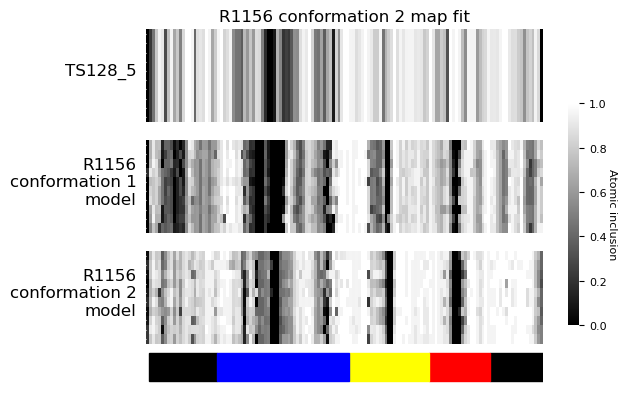

In [15]:
conf2_to_plot = conf2_models["per_res_AI_0.189"].to_numpy()
conf2_to_plot = np.tile(conf2_to_plot, (10, 1))
conf2_to_plot = np.vstack([conf2_to_plot, np.ones((2,conf2_to_plot.shape[1]))])
conf2_to_plot = np.vstack([conf2_to_plot,conf2_conf1native.pivot_table(index="entry",columns="residue",values="atom_inclusion").to_numpy()])
conf2_to_plot = np.vstack([conf2_to_plot, np.ones((2,conf2_to_plot.shape[1]))])
conf2_to_plot = np.vstack([conf2_to_plot,conf2_native.pivot_table(index="entry",columns="residue",values="per_res_AI_0.189").to_numpy()])
conf2_to_plot = np.vstack([conf2_to_plot, np.ones((6,conf2_to_plot.shape[1]))])

ylabels = ["","","","","TS128_5","","","","","","","","","","","","R1156\nconformation 1\nmodel","","","","","","","","","","","","R1156\nconformation 2\nmodel","","","","",""]
g=sns.heatmap(conf2_to_plot,cmap="gray",yticklabels = ylabels,cbar_kws={'shrink': 0.6})
g.set_title("R1156 conformation 2 map fit")
t=g.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=12)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Atomic inclusion",size=8,ha='center', rotation=-90, va='center')
t=g.set_xticks([])
g.tick_params(color='white', which='both')

from matplotlib.patches import Rectangle
g.add_patch(Rectangle((1, 35), 23-1+1, 3,color="black"))
g.add_patch(Rectangle((117, 35), 135-117+1, 3,color="black"))
g.add_patch(Rectangle((96, 35), 116-96+1, 3,color="red"))
g.add_patch(Rectangle((69, 35), 95-69+1, 3,color="yellow"))
g.add_patch(Rectangle((24, 35), 68-24+1, 3,color="blue"))
plt.savefig("R1156_example_AI_conf2.png",dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("R1156_example_AI_conf2.svg", bbox_inches='tight', transparent=True)

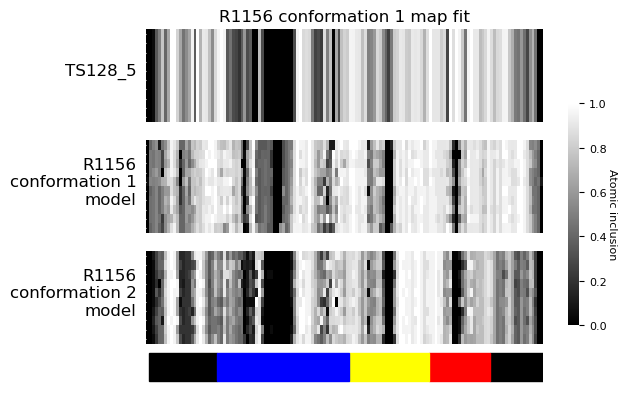

In [16]:
conf1_to_plot = conf1_models["per_res_AI_0.217"].to_numpy()
conf1_to_plot = np.tile(conf1_to_plot, (10, 1))
conf1_to_plot = np.vstack([conf1_to_plot, np.ones((2,conf1_to_plot.shape[1]))])
conf1_to_plot = np.vstack([conf1_to_plot,conf1_native.pivot_table(index="entry",columns="residue",values="per_res_AI_0.217").to_numpy()])
conf1_to_plot = np.vstack([conf1_to_plot, np.ones((2,conf1_to_plot.shape[1]))])
conf1_to_plot = np.vstack([conf1_to_plot,conf1_conf2native.pivot_table(index="entry",columns="residue",values="atom_inclusion").to_numpy()])
conf1_to_plot = np.vstack([conf1_to_plot, np.ones((6,conf1_to_plot.shape[1]))])
ylabels = ["","","","","TS128_5","","","","","","","","","","","","R1156\nconformation 1\nmodel","","","","","","","","","","","","R1156\nconformation 2\nmodel","","","","",""]
g=sns.heatmap(conf1_to_plot,cmap="gray",yticklabels = ylabels,cbar_kws={'shrink': 0.6})
g.set_title("R1156 conformation 1 map fit")
t=g.set_yticklabels(labels=g.get_yticklabels(),rotation = 0,size=12)
t=g.set_xticks([])
g.tick_params(color='white', which='both')

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Atomic inclusion",size=8,ha='center', rotation=-90, va='center')
g.add_patch(Rectangle((1, 35), 23-1+1, 3,color="black"))
g.add_patch(Rectangle((117, 35), 135-117+1, 3,color="black"))
g.add_patch(Rectangle((96, 35), 116-96+1, 3,color="red"))
g.add_patch(Rectangle((69, 35), 95-69+1, 3,color="yellow"))
g.add_patch(Rectangle((24, 35), 68-24+1, 3,color="blue"))
plt.savefig("R1156_example_AI_conf1.png",dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("R1156_example_AI_conf1.svg", bbox_inches='tight', transparent=True)